### KNN Classification
Disease-healthy cells approach: For each cell in the query
dataset, we extract its k nearest neighbors in the reference and the corresponding Euclidean
distances, adjusted by a Gaussian kernel. We compute the probability of assigning 𝑃(𝑦|𝑐)
each label to the query cell by normalising across all adjusted distances. The label 𝑦 𝑐
uncertainty corresponds to 1 − 𝑚𝑎𝑥_𝑦 (𝑃(𝑦|𝑐))

Steps:
1. Get all the distances
2. Extract for each cell in the QUERY the k nearest neighbors in the REFERENCE
3. Compute prob of assigning each label to the query cell by normalising across all adjusted distances
   
   3.1. Normalize
   
    3.2 Compute prob
4. Choose the best prob => uncert is 1 - best prob

In [1]:
import os
os.chdir('../') 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
import scanpy as sc
import torch
import scarches as sca
from scarches.dataset.trvae.data_handling import remove_sparsity
import matplotlib.pyplot as plt
import numpy as np
import gdown
import anndata as ad
import pandas as pd

 captum (see https://github.com/pytorch/captum).
INFO:lightning_fabric.utilities.seed:Global seed set to 0
/home/alextopalova/miniconda3/envs/archmap/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import milopy
import milopy.core as milo
from uncert_metric import *

In [4]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(3, 3))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

# Pancreas

In [5]:
condition_key = 'study'
cell_type_key = 'cell_type'
source_adata = sc.read("source/source__pancreas.h5ad")
target_adata = sc.read("target/target__pancreas.h5ad")
surgery_path = "surgery_model/surgery_model_pancreas"

In [6]:
model = sca.models.TRVAE.load(surgery_path, source_adata)

AnnData object with n_obs × n_vars = 10294 × 1000
    obs: 'batch', 'study', 'cell_type', 'size_factors'

INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 1000 128 5
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 5
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 1000 



In [7]:
adata_ref_latent = sc.AnnData(model.get_latent(source_adata.X, source_adata.obs[condition_key]))
adata_ref_latent.obs['cell_type'] = source_adata.obs[cell_type_key].tolist()
adata_ref_latent.obs['batch'] = source_adata.obs[condition_key].tolist()

In [8]:
adata_query_latent = sc.AnnData(model.get_latent(target_adata.X, target_adata.obs[condition_key]))
adata_query_latent.obs['cell_type'] = target_adata.obs[cell_type_key].tolist()
adata_query_latent.obs['batch'] = target_adata.obs[condition_key].tolist()

In [9]:
adata_query_latent

AnnData object with n_obs × n_vars = 5387 × 10
    obs: 'cell_type', 'batch'

In [10]:
uncertainties = classification_uncert_euclidean(
    adata_ref_latent = adata_ref_latent, 
    adata_query_latent = adata_query_latent,
    cell_type_key = "cell_type"
)

Weighted KNN with n_neighbors = 15 ... finished!


In [11]:
uncertainties["uncertainty"] = uncertainties["cell_type"]
uncertainties["batch"] = target_adata.obs[condition_key].tolist()
uncertainties["cell_type"] = target_adata.obs[cell_type_key].tolist()

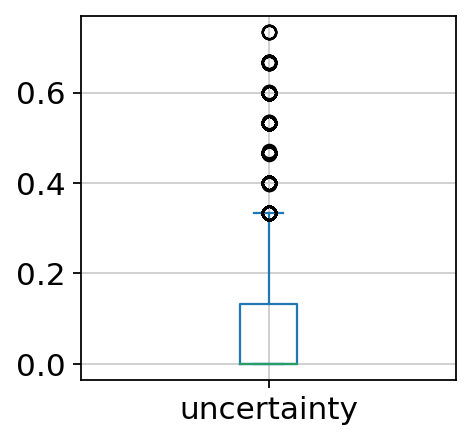

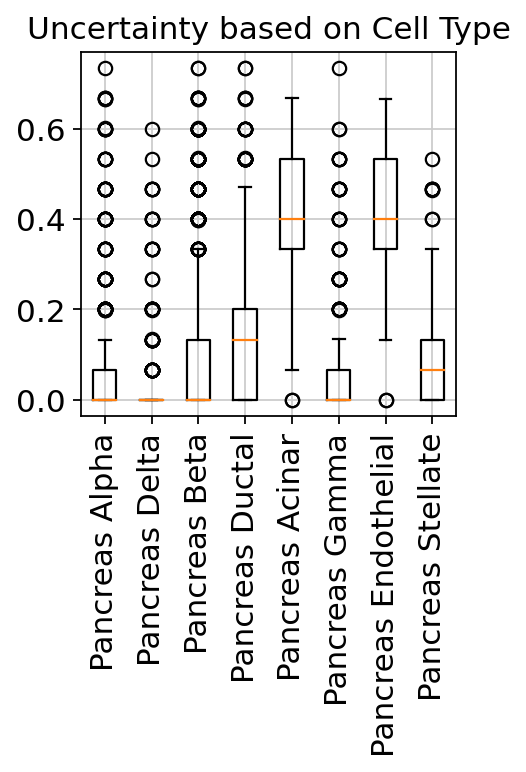

In [12]:
uncert_diagram(uncertainties, cell_type_key)

/home/alextopalova/miniconda3/envs/archmap/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/alextopalova/miniconda3/envs/archmap/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/alextopalova/miniconda3/envs/archmap/lib/python3

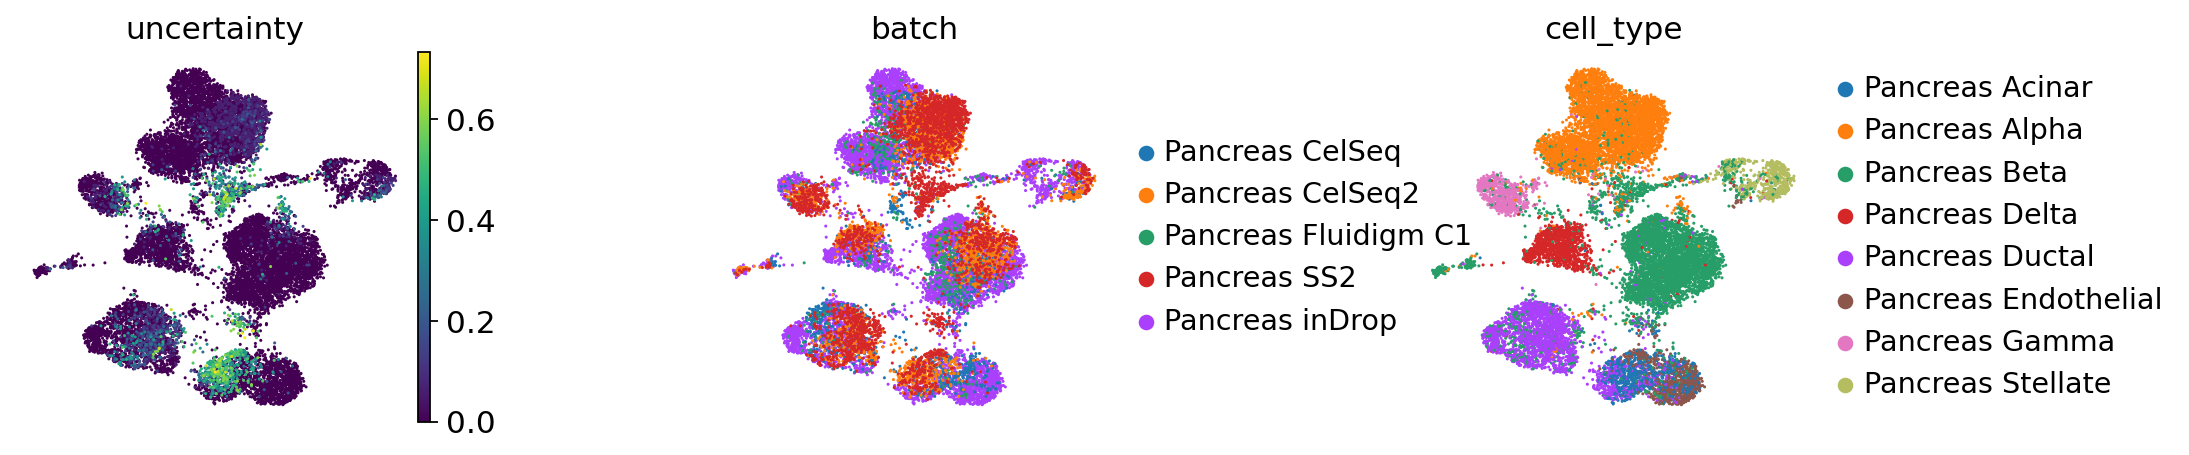

In [13]:
uncert_umap_diagram(
        adata_ref_latent,
        adata_query_latent,
        uncertainties["uncertainty"],
        batch_key = "batch",
        cell_type_key = "cell_type")

# Pancreas no alpha cells in reference

In [14]:
condition_key = 'study'
cell_type_key = 'cell_type'
source_adata = sc.read("source/source__pancreas_no_alpha.h5ad")
target_adata = sc.read("target/target__pancreas_no_alpha.h5ad")
surgery_path = "surgery_model/surgery_model_pancreas_no_alpha"

In [15]:
model = sca.models.TRVAE.load(surgery_path, source_adata)

AnnData object with n_obs × n_vars = 7584 × 1000
    obs: 'batch', 'study', 'cell_type', 'size_factors'

INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 1000 128 5
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 5
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 1000 



In [16]:
adata_ref_latent = sc.AnnData(model.get_latent(source_adata.X, source_adata.obs[condition_key]))
adata_ref_latent.obs['cell_type'] = source_adata.obs[cell_type_key].tolist()
adata_ref_latent.obs['batch'] = source_adata.obs[condition_key].tolist()

In [17]:
adata_query_latent = sc.AnnData(model.get_latent(target_adata.X, target_adata.obs[condition_key]))
adata_query_latent.obs['cell_type'] = target_adata.obs[cell_type_key].tolist()
adata_query_latent.obs['batch'] = target_adata.obs[condition_key].tolist()

In [18]:
uncertainties = classification_uncert_euclidean(
    adata_ref_latent = adata_ref_latent, 
    adata_query_latent = adata_query_latent,
    cell_type_key = "cell_type"
)

Weighted KNN with n_neighbors = 15 ... finished!


In [19]:
uncertainties["uncertainty"] = uncertainties["cell_type"]
uncertainties["batch"] = target_adata.obs[condition_key].tolist()
uncertainties["cell_type"] = target_adata.obs[cell_type_key].tolist()

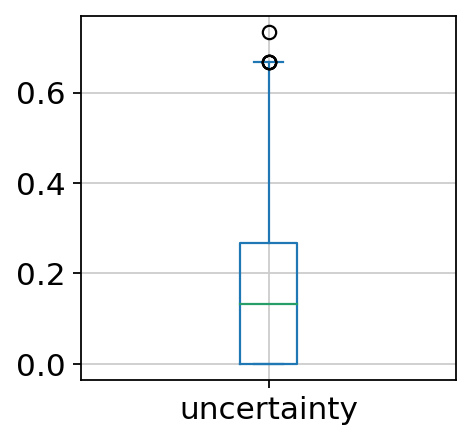

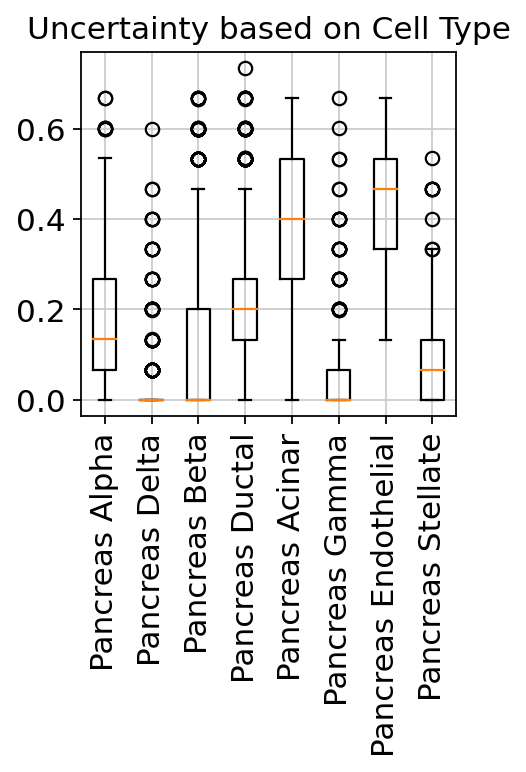

In [20]:
uncert_diagram(uncertainties, cell_type_key)

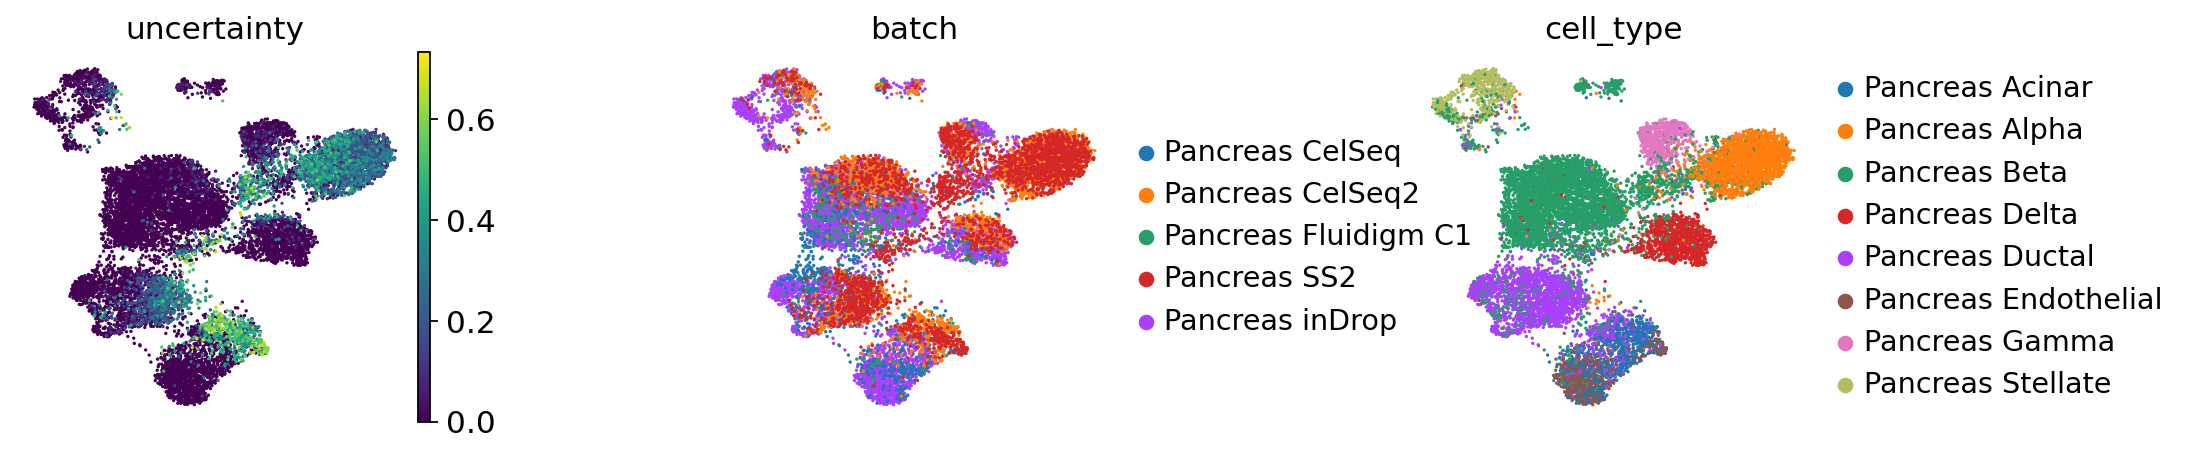

In [21]:
uncert_umap_diagram(
        adata_ref_latent,
        adata_query_latent,
        uncertainties["uncertainty"],
        batch_key = "batch",
        cell_type_key = cell_type_key)

# PBMC normal

In [22]:
condition_key = 'batch' 
cell_type_key = 'final_annotation'
source_adata = sc.read("source/source__pbmc.h5ad")
target_adata = sc.read("target/target__pbmc.h5ad")
surgery_path = "surgery_model/surgery_model_pbmc"

In [23]:
model = sca.models.TRVAE.load(surgery_path, source_adata)

AnnData object with n_obs × n_vars = 29195 × 12303
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'

INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 12303 128 10
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 10
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 12303 



In [24]:
adata_ref_latent = sc.AnnData(model.get_latent(source_adata.X, source_adata.obs[condition_key]))
adata_ref_latent.obs['cell_type'] = source_adata.obs[cell_type_key].tolist()
adata_ref_latent.obs['batch'] = source_adata.obs[condition_key].tolist()

In [25]:
adata_query_latent = sc.AnnData(model.get_latent(target_adata.X, target_adata.obs[condition_key]))
adata_query_latent.obs['cell_type'] = target_adata.obs[cell_type_key].tolist()
adata_query_latent.obs['batch'] = target_adata.obs[condition_key].tolist()

In [26]:
uncertainties = classification_uncert_euclidean(
    adata_ref_latent = adata_ref_latent, 
    adata_query_latent = adata_query_latent,
    cell_type_key = "cell_type"
)

Weighted KNN with n_neighbors = 15 ... finished!


In [27]:
uncertainties["uncertainty"] = uncertainties["cell_type"]
uncertainties["batch"] = target_adata.obs[condition_key].tolist()
uncertainties["cell_type"] = target_adata.obs[cell_type_key].tolist()

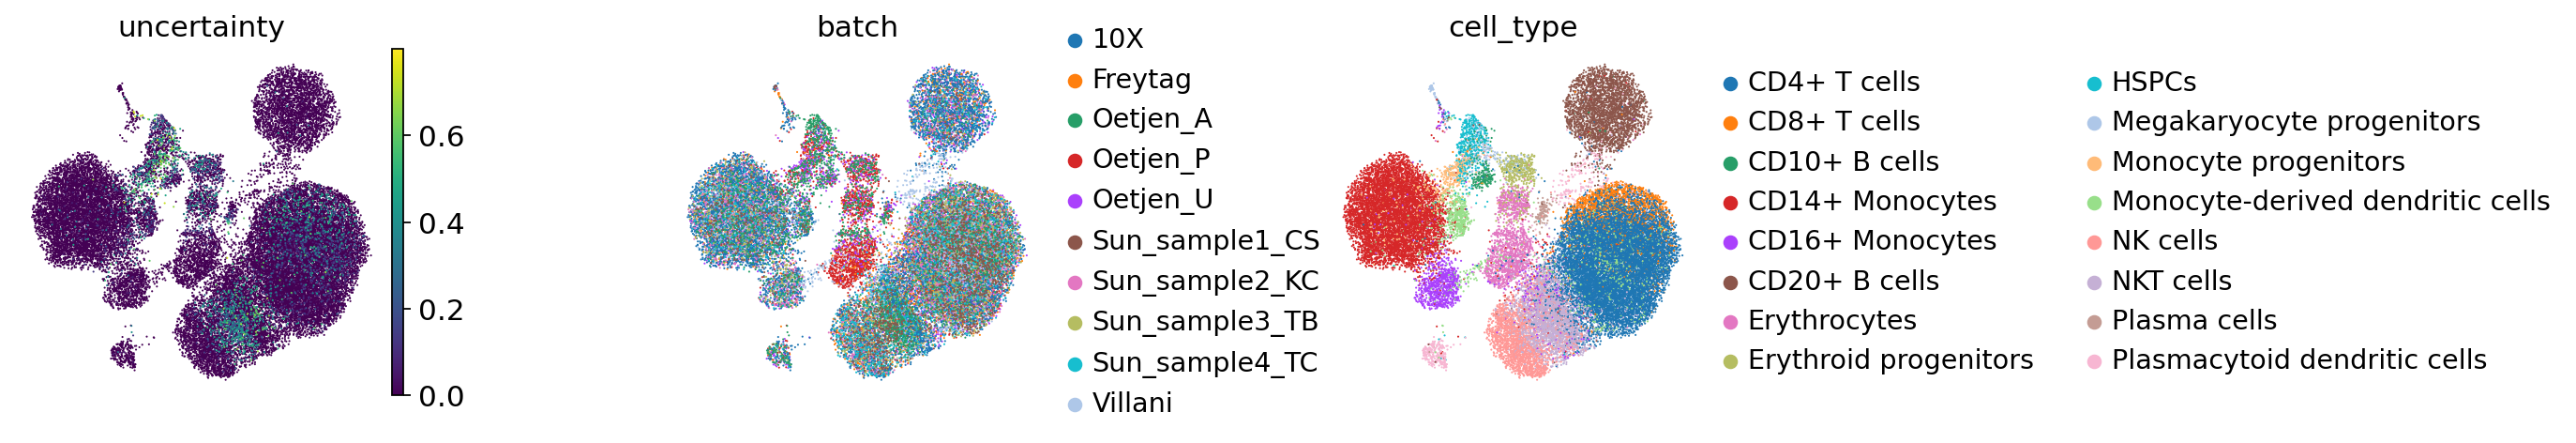

In [29]:
uncert_umap_diagram(
        adata_ref_latent,
        adata_query_latent,
        uncertainties["uncertainty"],
        batch_key = "batch",
        cell_type_key = "cell_type")

# PBMC 10X and Villani

In [30]:
condition_key = 'batch' 
cell_type_key = 'final_annotation'
source_adata = sc.read("source/source__pbmc_10x_villani.h5ad")
target_adata = sc.read("target/target__pbmc_10x_villani.h5ad")
surgery_path = "surgery_model/surgery_model_pbmc_10x_villani"

In [31]:
model = sca.models.TRVAE.load(surgery_path, source_adata)

AnnData object with n_obs × n_vars = 21757 × 12303
    obs: 'batch', 'chemistry', 'data_type', 'dpt_pseudotime', 'final_annotation', 'mt_frac', 'n_counts', 'n_genes', 'sample_ID', 'size_factors', 'species', 'study', 'tissue'
    layers: 'counts'

INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 12303 128 10
	Hidden Layer 1 in/out: 128 128
	Mean/Var Layer in/out: 128 10
Decoder Architecture:
	First Layer in, out and cond:  10 128 10
	Hidden Layer 1 in/out: 128 128
	Output Layer in/out:  128 12303 



In [32]:
adata_ref_latent = sc.AnnData(model.get_latent(source_adata.X, source_adata.obs[condition_key]))
adata_ref_latent.obs['cell_type'] = source_adata.obs[cell_type_key].tolist()
adata_ref_latent.obs['batch'] = source_adata.obs[condition_key].tolist()

In [33]:
adata_query_latent = sc.AnnData(model.get_latent(target_adata.X, target_adata.obs[condition_key]))
adata_query_latent.obs['cell_type'] = target_adata.obs[cell_type_key].tolist()
adata_query_latent.obs['batch'] = target_adata.obs[condition_key].tolist()

In [34]:
uncertainties = classification_uncert_euclidean(
    adata_ref_latent = adata_ref_latent, 
    adata_query_latent = adata_query_latent,
    cell_type_key = "cell_type"
)

Weighted KNN with n_neighbors = 15 ... finished!


In [35]:
uncertainties["uncertainty"] = uncertainties["cell_type"]
uncertainties["batch"] = target_adata.obs[condition_key].tolist()
uncertainties["cell_type"] = target_adata.obs[cell_type_key].tolist()

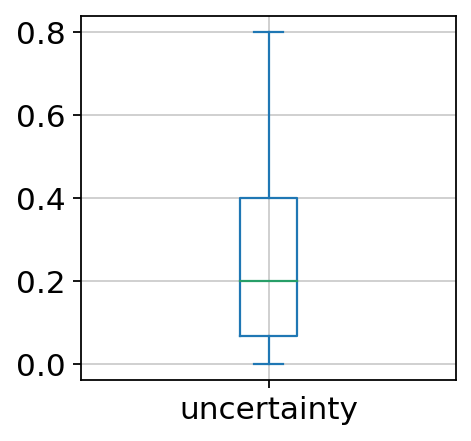

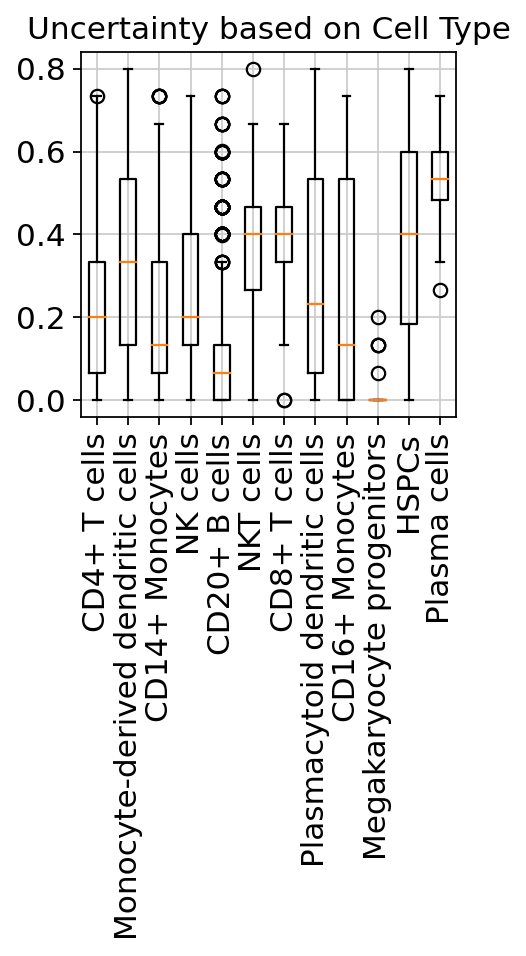

In [37]:
uncert_diagram(uncertainties, "cell_type")

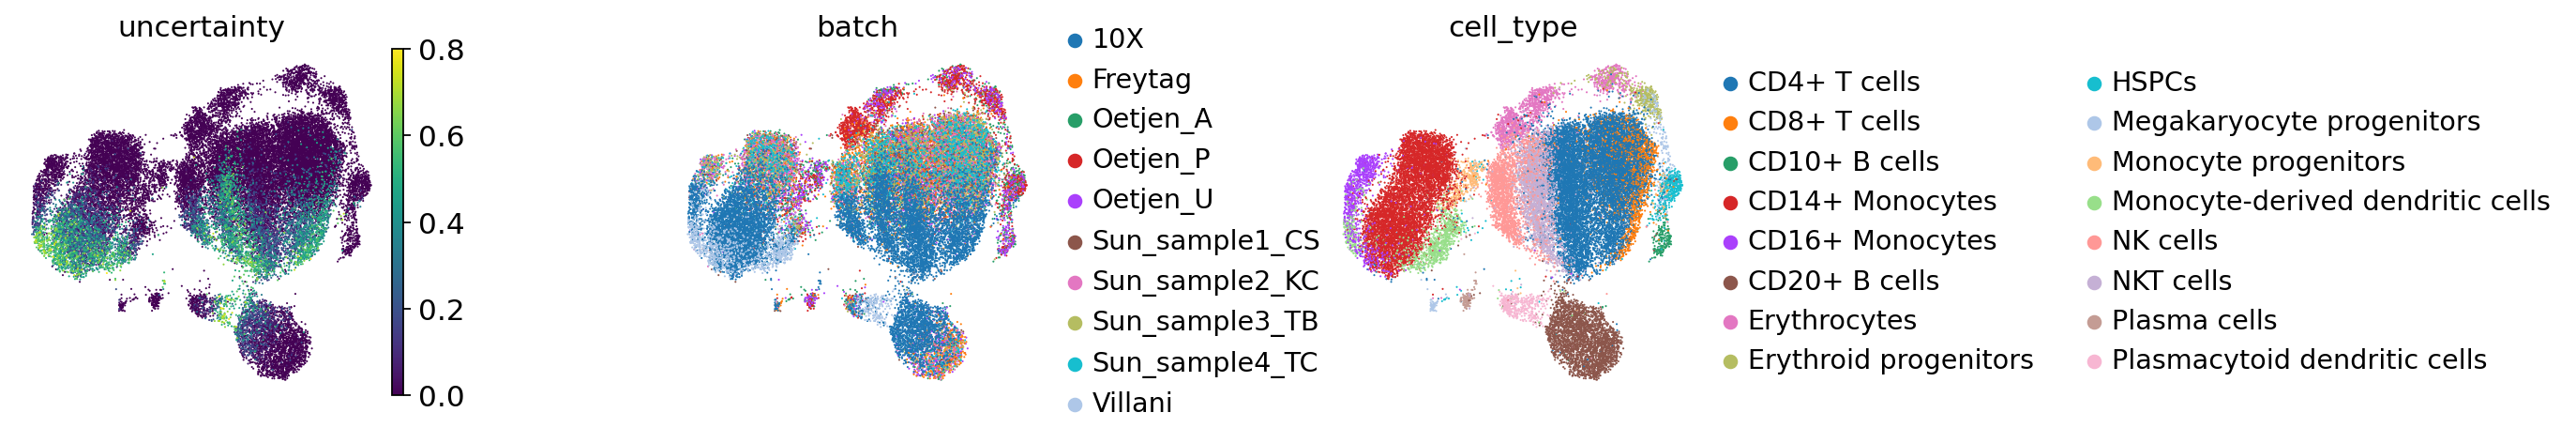

In [38]:
uncert_umap_diagram(
        adata_ref_latent,
        adata_query_latent,
        uncertainties["uncertainty"],
        batch_key = "batch",
        cell_type_key = "cell_type")